#### **Using Implied Cost of Capital as a Sector ETF Valuation Tool**
#### _[Monday 7.6.2015]_
------------

***This is a follow-up to these posts [here](http://blkarb.se/1FCBL1R) and [here](http://blkarb.se/1HJ3tsR) where I detail the `ICC` methodology used. All the data and plots have been updated and reflects current information. Scroll to the bottom to see the results of our previous predictions.*** 

The following IPython Notebook examines the **Implied Cost of Capital (ICC)** method of valuation for purposes of trade/portfolio positioning. The **ICC** model is a forward looking estimate that uses earnings forecasts to calculate an implied earnings growth rate. The goal of this analysis is to identify asymmetric investing opportunities due to incongruence between *"recent"* historical returns and forward looking expectations of earnings growth (as measured by the ICC). 

**_Please note:_** _there will be some category overlap as some of the groupings include international sector ETF's while other groupings contain regional and/or country ETF's._ 
____


In [1]:
# ================================================================== #
# composite returns; vol; risk adjusted returns; correlation matrix, ICC analysis

import pandas as pd
import numpy as np
import pandas.io.data as web
from   pandas.tseries.offsets import *
import datetime as dt

pd.set_option('colheader_justify', 'right')

import matplotlib.pyplot as plt
%matplotlib inline
size=(10,8)

import seaborn as sns
sns.set_style('white')

import plotly.plotly as py
from   plotly.graph_objs import *
import plotly.tools as tls

import cufflinks 

In [2]:
# ================================================================== #
# datetime management

num_weeks = 3 # number of weeks since last update

date_today = dt.date.today()
d_mon, d_day = date_today.month, date_today.day

prev_date_today = date_today - num_weeks * Week(weekday=0) # weekday 0 = Monday
pre_d_mon, pre_d_day = prev_date_today.month, prev_date_today.day

pprev_dt_today = date_today - 2 * num_weeks * Week(weekday=0)
pprev_d_mon, pprev_d_day = pprev_dt_today.month, pprev_dt_today.day

last_month = date_today - 21 * BDay() # switch to 21
one_year_ago = date_today - 252 * BDay()

In [3]:
# ~~~ Market Cap ~~~ #
Broad_mkts = ['THRK','RSCO'] # Russell 3000, Russell Small Cap Completeness
Large_cap  = ['ONEK','SPY','SPYG','SPYV'] # Russell 1000, sp500 (growth, value)
Mid_cap    = ['MDY','MDYG', 'MDYV'] # sp400 mid (growth, value)
Small_cap  = ['TWOK','SLY','SLYG','SLYV'] # russ 2K, sp600, (growth, value)

# ~~~ International/Global Equities ~~~ #
Global = [
        'DGT', #  global dow
        'BIK', # sp BRIC 40 ETF
        'GMM', # sp emerging mkts 
        'EWX', # sp emerging mkts small caps
        'CWI', # msci acwi ex-US
        'GII', # global infrastructure
        'GNR', # global natural resources
        'DWX', # intl dividends
        'GWL', # sp developed world ex-US 
        'MDD', # intl mid cap (2B-5B USD)
        'GWX'  # intl small cap (<2B USD)
        ]

Asia   = ['JPP','JSC','GXC','GMF'] # japan, smallcap japan, china, emg asiapac
Europe = ['FEZ','GUR','RBL','FEU'] # euro stoxx 50, emg europe, russia, stoxx europe 50
Latam  = ['GML'] # emg latin america
Africa = ['GAF'] # emg mideast/africa

# ~~~ Real Assets ~~~ #
Real_assets = [ 'RWO', # global real estate
                'RWX', # intl real estate ex-US
                'RWR'  # US select REIT
                ]        

# ~~~ sectors and industries ETF's ~~~ #
Sector = [
          'XLY','XHB','IPD','XRT',                   # consumer discretionary
          'XLP','IPS',                               # consumer staples
          'XLE','IPW','XES','XOP',                   # energy
          'XLF','KBE','KCE','KIE','IPF','KRE',       # financials
          'XLV','XBI','XHE','XHS','IRY','XPH',       # healthcare
          'XLI','XAR','IPN','XTN',                   # industrial
          'XLB','IRV','XME',                         # materials
          'XLK','MTK','IPK','XSD','XSW',             # technology
          'IST','XTL',                               # telecom
          'IPU','XLU'                                # utilities
          ]
   
stock_list = [Broad_mkts, Large_cap, Mid_cap, Small_cap, Global, Asia, Europe, Latam, Africa, Real_assets, Sector]

# ~~~ Category structure ~~~ #
cat = {'Broad_Market'          :['THRK','RSCO'],
       'Large_Cap'             :['ONEK','SPY','SPYG','SPYV'],
       'Mid_Cap'               :['MDY','MDYG', 'MDYV'], 
       'Small_Cap'             :['TWOK','SLY','SLYG','SLYV'],
       'Global_Equity'         :['DGT','BIK','GMM','EWX','CWI','GII','GNR','DWX','GWL','MDD','GWX'],
       'AsiaPac_Equity'        :['JPP','JSC','GXC','GMF'],
       'Europe_Equity'         :['FEZ','GUR','RBL','FEU'],
       'Latam_MidEast_Africa'  :['GML','GAF'],
       'Real_Estate'           :['RWO','RWX','RWR'],
       'Consumer_Discretionary':['XLY','XHB','IPD','XRT'],
       'Consumer_Staples'      :['XLP','IPS'],                         
       'Energy'                :['XLE','IPW','XES','XOP'],                   
       'Financials'            :['XLF','KBE','KCE','KIE','IPF','KRE'],
       'Healthcare'            :['XLV','XBI','XHE','XHS','IRY','XPH'],
       'Industrial'            :['XLI','XAR','IPN','XTN'],
       'Materials'             :['XLB','IRV','XME'],
       'Technology'            :['XLK','MTK','IPK','XSD','XSW'],
       'Telecom'               :['IST','XTL'],                            
       'Utilities'             :['IPU','XLU']
        }    

filepath   = r'C:\Users\Owner\Documents\Visual_Studio_2013\Projects\iVC_Reporting_Engine\PythonApplication2\\'

In [4]:
# ================================================================== #
# get prices
def get_px(stock, start, end):
    '''
    Function to call Pandas' Yahoo Finance API to get daily stock prices.
    '''     
    try:
        return web.DataReader(stock, 'yahoo', start, end)['Adj Close']
    except Exception as e:
        print( 'something is fucking up' )

px = pd.DataFrame()
for category in stock_list:
    for stock in category:
        px[stock] = get_px( stock, one_year_ago, date_today )
        
# ================================================================== #
# construct dataframe and proper multi index
log_rets          = np.log( px / px.shift(1) ).dropna()
lrets             = log_rets.T.copy()
lrets.index.name  = 'ETF'
lrets['Category'] = pd.Series()

for cat_key, etf_val in cat.items():
    for val in etf_val:
        if val in lrets.index:
            idx_loc                      = lrets.index.get_loc(val)
            lrets.ix[idx_loc,'Category'] = cat_key
        else:
            pass

lrets.set_index('Category', append=True, inplace=True)
lrets = lrets.swaplevel('ETF','Category').sortlevel('Category')
# lrets.head()       

# ================================================================== #
# cumulative returns of ETF's
cum_rets = lrets.groupby(level='Category').cumsum(axis=1)
# cum_rets.head()

# ================================================================== #
# composite groupings of cumulative ETF returns (equally weighted intra-category mean returns)
composite_rets = pd.DataFrame()
for label in cat.keys():
    composite_rets[label] = cum_rets.ix[label].mean(axis=0) # equal weighted mean
    
comp_rets = np.round(composite_rets.copy(),4) # rounding

In [5]:
# ~~~~~ Additional risk and return computations ~~~~~ #

# ================================================================== #
# composite rolling std

sigmas = lrets.groupby(level='Category').std() # equal weighted std

composite_sigs = pd.DataFrame()
for label in cat.keys():
    composite_sigs[label] = sigmas.ix[label] 

rsigs = pd.rolling_mean( composite_sigs, window=60 ).dropna()*np.sqrt(60)

# ================================================================== #
# composite rolling risk adjusted returns

mean_rets = lrets.groupby(level='Category').mean() # equal weighted mean

composite_risk_rets = pd.DataFrame()
for label in cat.keys():
    composite_risk_rets[label] = mean_rets.ix[label] 

rs = pd.rolling_mean( composite_risk_rets, window=60 ).dropna() 
risk_rets = rs/rsigs

# ================================================================== #
# correlation matrix of composite ETF groups' risk adjusted returns
cor = risk_rets.corr()

### Current ICC Estimates and Rankings

In [6]:
# ================================================================== #
# import ICC estimates
frame = pd.read_csv( filepath+'Spdr_ICC_est_{}.csv'.format(date_today)) #.dropna()
pre_frame = pd.read_csv( filepath+'Spdr_ICC_est_{}.csv'.format(prev_date_today.date()), index_col=0 ) #.dropna() 

# ================================================================== #
# group ICC data by category

# ~~~~ setup current estimates
f            = frame.copy()
grp          = f.groupby('Category')
grp_mean     = grp.mean().sort('ETF_ICC_est', ascending=False)
grp_mean_rnd = grp_mean['ETF_ICC_est'].round(3)
grp_mean     = pd.DataFrame( grp_mean_rnd )

# ~~~~ setup last updates' estimates
pre_f        = pre_frame[['ETF_ICC_est','Category']]
pre_grp      = pre_f.groupby('Category')
pre_grp_mean = pre_grp.mean().sort('ETF_ICC_est', ascending=False) 
pre_grp_mean = np.round( pre_grp_mean, 3 )

# ~~~~ setup combined dataframe using current df est.
gm_cols                       = ['Current ICC Est', 'Rank', 'Previous ICC Est', 'Previous Rank', 'Change in Rank']
grp_mean['Rank']              = grp_mean.rank(ascending=False, method='dense')
grp_mean['Previous ICC est']  = pre_grp_mean
grp_mean['Previous Rank']     = pre_grp_mean.rank(ascending=False, method='dense')
grp_mean['Change in Ranking'] = grp_mean['Previous Rank'] - grp_mean['Rank']
grp_mean.columns              = gm_cols
grp_mean

,Current ICC Est,Rank,Previous ICC Est,Previous Rank,Change in Rank
Category,,,,,
Mid_Cap,1.891,1,0.132,13,12
Broad_Market,0.263,2,0.130,15,13
Europe_Equity,0.242,3,0.234,1,-2
Financials,0.232,4,0.228,2,-2
Energy,0.228,5,0.187,5,0
Materials,0.209,6,0.177,7,1
AsiaPac_Equity,0.209,6,0.202,3,-3
Utilities,0.204,7,0.190,4,-3
Global_Equity,0.191,8,0.183,6,-2


### Z-Score of ICC Estimates by Category

**NOTE:** The **Midcap** composite is currently providing an unusable result. I'm still digging into the issue but it appears to be a combination of factors primarily arising from a change or mismatch in data from Spdrs.com. The Price/Book ratio is unrealistically small for some reason `(<0.4)` which I suspect is an error.

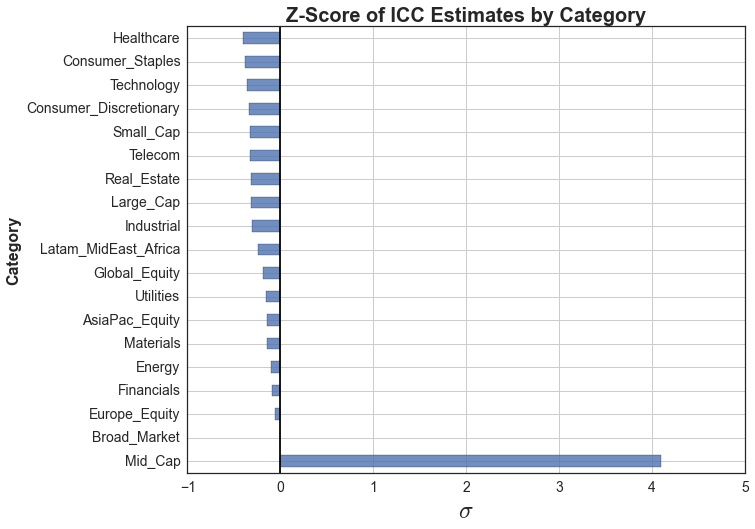

In [7]:
def z_score(df):
    return ( df - df.mean() ) / df.std()

z_grp = z_score(grp_mean['Current ICC Est'])

plt.figure()
size = (10, 8)
z_grp.plot('barh', figsize=size, alpha=.8)
plt.axvline(0, color='k')
plt.title('Z-Score of ICC Estimates by Category', fontsize=20, fontweight='demibold')
plt.xlabel('$\sigma$', fontsize=24)
plt.ylabel('Category', fontsize=16, fontweight='demibold')
plt.tick_params(axis='both', which='major', labelsize=14)


### Cumulative Log Returns and Rankings - L/21 Days 

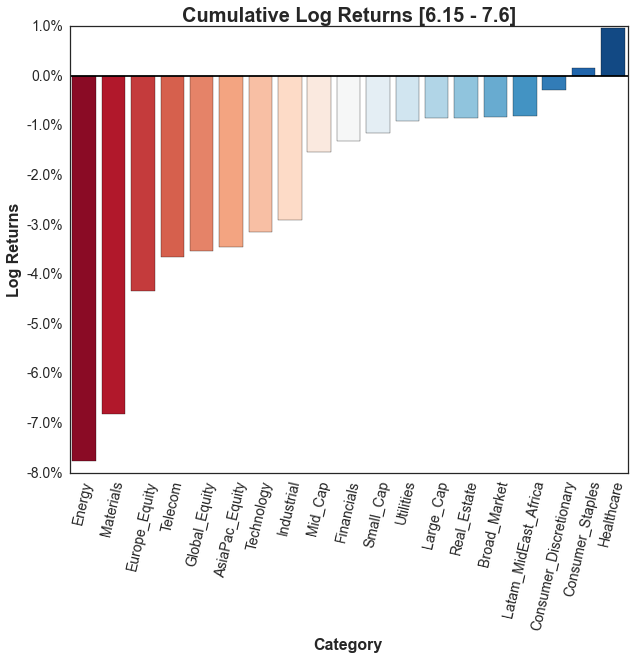

In [8]:
# ================================================================== #
# construct dataframe and proper multi index
log_rets_recent = np.log( px.ix[prev_date_today.date():] / px.ix[prev_date_today.date():].shift(1) ).dropna()

lrets_recent = log_rets_recent.T.copy()
lrets_recent.index.name = 'ETF'
lrets_recent['Category'] = pd.Series()

for cat_key, etf_val in cat.items():
    for val in etf_val:
        if val in lrets_recent.index:
            idx_loc = lrets_recent.index.get_loc(val)
            lrets_recent.ix[idx_loc,'Category'] = cat_key
        else:
            pass

lrets_recent.set_index('Category', append=True, inplace=True)
lrets_recent = lrets_recent.swaplevel('ETF','Category').sortlevel('Category')
lrets_recent.head()       

# ================================================================== #
# cumulative returns of ETF's
cum_rets_recent = lrets_recent.groupby(level='Category').cumsum(axis=1)
cum_rets_recent.head();

# ================================================================== #
# composite groupings of cumulative ETF returns (equally weighted intra-category mean returns)
composite_rets_recent = pd.DataFrame()
for label in cat.keys():
    composite_rets_recent[label] = cum_rets_recent.ix[label].mean(axis=0) # equal weighted mean
    
crr = np.round(composite_rets_recent.copy(),4) # rounding
# ================================================================== #
import matplotlib
from matplotlib.ticker import FuncFormatter

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)
    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] == True:
        return s + r'$\%$'
    else:
        return s + '%'
# ================================================================== #
# Create the formatter using the function to_percent. This multiplies all the default labels by 100
formatter = FuncFormatter(to_percent)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# setup bar returns dataframe
bar_rets         = crr.ix[-1:].T.sort() #'{}'.format(date_today - 3 * BDay()) ) # Thurs was holiday
bar_rets         = bar_rets.reset_index()
dt_txt_fmt       = '[{pm}.{prd} - {m}.{d}]'.format(pm=pre_d_mon, prd=pre_d_day,m=d_mon,d=d_day)
cols             = ['index', dt_txt_fmt]
bar_rets.columns = cols
bar_rets         = bar_rets.set_index('index', drop=True)
bar_rets         = bar_rets.sort(dt_txt_fmt)
bar_rets
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# plot code
f = plt.figure(figsize=size)
order = bar_rets[dt_txt_fmt].argsort() # bug in seaborn; needed to order barplot correctly
odr = order.index.tolist()
sns.barplot( x=bar_rets.index, y=bar_rets[dt_txt_fmt], x_order=odr, palette='RdBu')
plt.xticks(rotation=77)
plt.axhline(0, color='k')
plt.title('Cumulative Log Returns {}'.format(dt_txt_fmt), fontsize=20, fontweight='demibold')
#plt.xticks(bar_rets.index, bar_rets['index'])
plt.xlabel('Category', fontsize=16, fontweight='demibold')
plt.ylabel('Log Returns', fontsize=16, fontweight='demibold')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.gca().yaxis.set_major_formatter(formatter)

In [9]:
# ================================================================== #
# Create log return dataframe ranking comparison to last period

# ~~~~ setup current df of log returns ranking
curr_lrets    = bar_rets.copy()
curr_grp      = curr_lrets # already grouped #curr_grp      = curr_lrets.groupby('index')
curr_grp_mean = curr_grp.sort(dt_txt_fmt, ascending=False) 
curr_grp_mean.to_csv(filepath + 'Cum Log Returns ranks_{}.csv'.format(date_today))

# ~~~~ setup previous df of log return ranking
prev_dt_txt_fmt = '[{ppm}.{pprd} - {pm}.{prd}]'.format(ppm=pprev_d_mon, pprd=pprev_d_day, pm=pre_d_mon, prd=pre_d_day)

# import previous cumulative returns 
pre_lrets = pd.read_csv( filepath+'Cum Log Returns_ranks_{}.csv'.format(prev_date_today.date()), index_col=0).dropna()
#pre_lrets # columns: ['Cum. log returns [pprev_month.pprev_day - prev_month.prev_day]','Rank']

# ~~~~ setup combined dataframe using current log return rankings
lret_rank_cols                         = ['Current Cum. Returns {}'.format(dt_txt_fmt), 'Rank', 'Previous Cum. Returns {}'.format(prev_dt_txt_fmt), 'Previous Rank', 'Change in Rank']
curr_grp_mean['Rank']                  = curr_grp_mean.rank(ascending=False, method='dense')
curr_grp_mean['Previous Cum. Returns'] = pre_lrets['Cum. log returns {}'.format(prev_dt_txt_fmt)]
curr_grp_mean['Previous Rank']         = pre_lrets['Rank']
curr_grp_mean['Change in Ranking']     = curr_grp_mean['Previous Rank'] - curr_grp_mean['Rank']
curr_grp_mean.columns                  = lret_rank_cols
curr_grp_mean.index.name               = 'Category'
curr_grp_mean

,Current Cum. Returns [6.15 - 7.6],Rank,Previous Cum. Returns [5.25 - 6.15],Previous Rank,Change in Rank
Category,,,,,
Healthcare,0.0096,1,0.0158,3,2
Consumer_Staples,0.0016,2,-0.0133,12,10
Consumer_Discretionary,-0.0028,3,0.0055,8,5
Latam_MidEast_Africa,-0.0081,4,-0.0282,18,14
Broad_Market,-0.0082,5,0.0058,6,1
Real_Estate,-0.0084,6,-0.0245,16,10
Large_Cap,-0.0085,7,-0.0026,9,2
Utilities,-0.0091,8,-0.0275,17,9
Small_Cap,-0.0114,9,0.0233,2,-7


### Z-Score Average Risk-Adjusted Returns - L/21 days

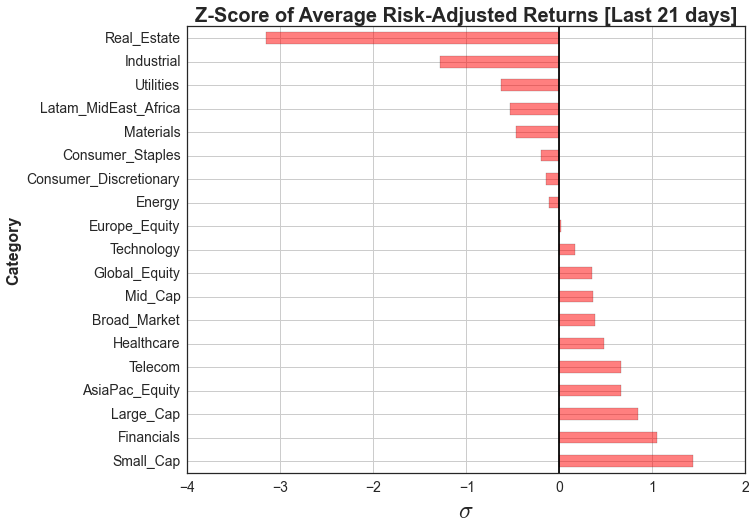

In [10]:
# last 21 days average category risk adjusted returns
date_mask = last_month
l_month = risk_rets.ix[date_mask:].mean().order(ascending=False) 
l_month

# z scored and plotted
z_l_21 = z_score(l_month)

plt.figure()
z_l_21.plot('barh', figsize=size, color='r', alpha=.5)
plt.axvline(0, color='k')
plt.title('Z-Score of Average Risk-Adjusted Returns [Last 21 days]', fontsize=20, fontweight='demibold')
plt.xlabel('$\sigma$', fontsize=24)
plt.ylabel('Category', fontsize=16, fontweight='demibold')
plt.tick_params(axis='both', which='major', labelsize=14)

### Z-Score Comparison [ICC Estimates vs. Risk-Adjusted Returns]

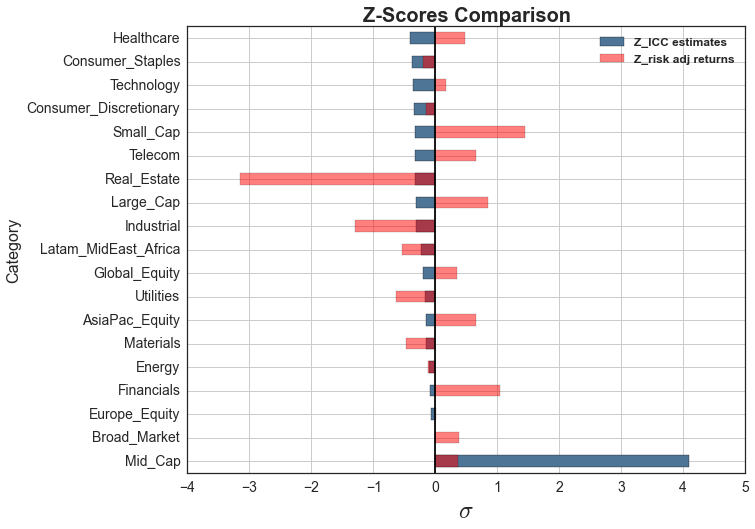

In [11]:
z_data                       = pd.DataFrame()
z_data['Z_ICC estimates']    = z_grp
z_data['Z_risk adj returns'] = z_l_21

cadet_blue = '#4e7496'

fig = plt.figure()
with pd.plot_params.use('x_compat', True):
    z_data['Z_ICC estimates'].plot('barh', figsize=size, color=cadet_blue)
    z_data['Z_risk adj returns'].plot('barh',figsize=size, color='r', alpha=.5)
plt.axvline(0, color='k')
plt.title('Z-Scores Comparison', fontsize=20, fontweight='demibold')
plt.xlabel('$\sigma$', fontsize=24, fontweight='demibold')
plt.ylabel('Category', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc='best', prop={'weight':'demibold','size':12})

# Interpretation
---
### Potential Long Positions:
___
- **Financials:** Not much has changed in terms of strategic position targeting. **Recent relative performance supports my previous note where I advocated finding suitable entry points** for long positions. I view the current volatility and weakness in broad markets as a potential attractive entry point into certain names and industries within the financial sector. **My previous research has shown that investing in financial industries given rising rates is a positive expectation investment since ~2002.** Furthermore I will use future blog posts to support or reject specific industry targets, such as property/casualty insurance firms. 
- **Real-Estate** and/or **Utilities:** The following investment thesis is mostly unchanged since the last update. **This would be a tactical diversification/hedging trade.** As a result of rising inflation expectations, interest rate sensitive sectors have been hammered. Should inflation fail to materialize or sentiment change there is likely to be tradeable reversal in both sectors. Additionally, **the real estate composite has been disproportionately weak compared to the other composites, showing a relative 3 standard deviation decline in risk adjusted returns.** 

### Potential Short Positions:
___
 - **Neutral bias:** 
 
### Notes:
___
 - The **Real-Estate** and **Utilities** sectors could just as easily be tactical short positions. Long term the writing is on the wall. The `Fed` *will* and *must* raise rates eventually. To do otherwise is extremely risky and likely short-sighted. Consider what happens in an economic downturn if rates still remain at/near zero. That would effectively leave the `Fed` with only `QE` as a policy response. This would go against the `Federal Reserve's` stated position that `QE` is reserved for extraordinary economic situations. 

In [12]:
# ~~~~~ plot code ~~~~~ 
# function to create Plotly 'Layout' object

def create_layout( main_title, y_title ):
    '''
    Function to create custom Plotly layout object to pass to Cufflinks df.iplot() method
    
    Parameters:
    ==========
    
    main_title = type('str')
    y_title    = type('str')

    Returns:
    ========
    plotly_layout = Plotly Layout object basically constructed using a JSON or Dict structure    
    '''    
    plotly_layout = Layout(
        # ~~~~ construct main title
            title=main_title,
            font=Font(
                family='Open Sans, sans-serif',
                size=14,
                color='SteelBlue'
            ),
        # ~~~~ construct X axis
        xaxis=XAxis(
            title='$Date$',
            titlefont=Font(
                family='Open Sans, sans-serif',
                size=14,
                color='SteelBlue'
            ),
            showticklabels=True,
            tickangle=-30,
            tickfont=Font(
                family='Open Sans, sans-serif',
                size=11,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'
        ),
        # ~~~~ construct Y axis
        yaxis=YAxis(
            title= y_title,
            titlefont=Font(
                family='Open Sans, sans-serif',
                size=14,
                color='SteelBlue'
            ),
            showticklabels=True,
            tickangle=0,
            tickfont=Font(
                family='Open Sans, sans-serif',
                size=11,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'),
        # ~~~~ construct figure size
            autosize=False,
            width=850,
            height=500,
            margin=Margin(
            l=50,
            r=20,
            b=60,
            t=50,
            pad=2
            ),
        # ~~~~ construct legend      
            legend=Legend(
            y=0.5,
            #traceorder='reversed',
            font=Font(
                family='Open Sans, sans-serif',
                size=9,
                color='Black'
        ),            
        )
    )
    return plotly_layout

# Additional Charts
___

### Cumulative Log Returns - L/252 Days

In [13]:
# test the function
title = '<b>Cumulative Log Returns of Composite ETF Sectors [1 Year]</b>'
y_label = '$Returns$'

custom_layout_1 = create_layout( title, y_label )
comp_rets.iplot(theme='white',filename='{}_{}'.format(title, date_today), layout=custom_layout_1, world_readable=True)

### 60-Day Rolling Standard Deviation

In [14]:
# ~~~~~ plot code
title = '<b>60-Day Rolling Standard Deviation</b>'
#y_label = r'$return \ \sigma$'
y_label = r'$\sigma \ of \ returns$'

custom_layout_2 = create_layout( title, y_label )
rsigs.iplot(theme='white',filename='{}_{}'.format(title, date_today), layout=custom_layout_2, world_readable=True)

### 60-Day Rolling Average of Risk-Adjusted Returns

In [15]:
# ~~~~~ plot code
title = r'<b>60 day Moving Average of Composite Risk-Adjusted Returns</b>'
y_label = '$\mu/\sigma$$'

custom_layout_3 = create_layout( title, y_label )
risk_rets.iplot(theme='white', filename='{}_{}'.format(title, date_today), layout=custom_layout_3, world_readable=True)

### Composite ETF Correlation Heat Map

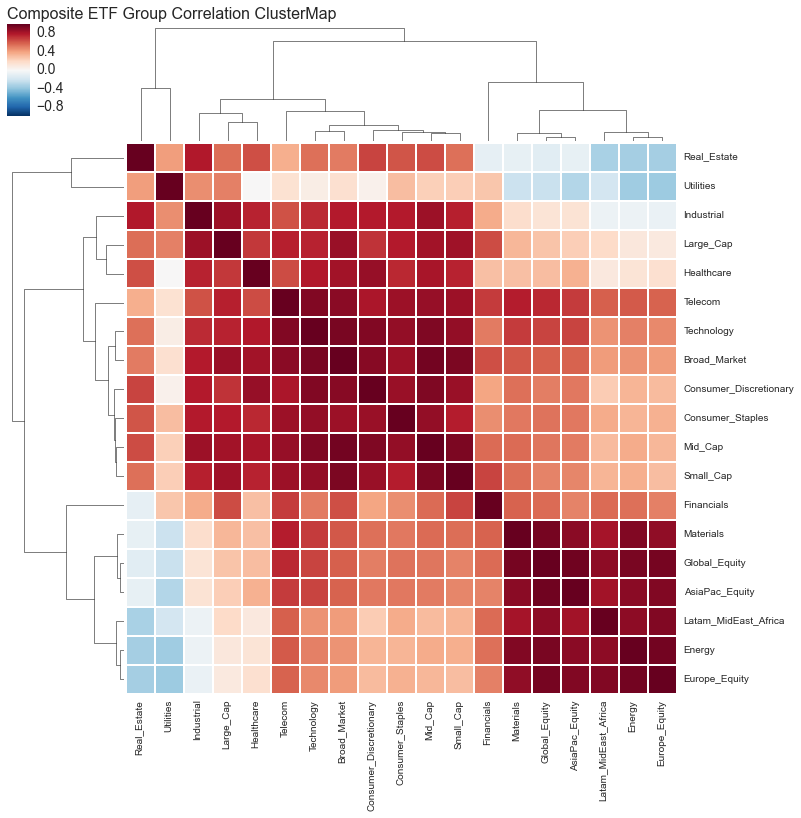

In [16]:
f = plt.figure()
sns.clustermap(cor, figsize=(12,12))
plt.title('Composite ETF Group Correlation ClusterMap', fontsize=16, loc='left')
plt.tick_params(axis='both', labelsize=14)

### Composite ETF Correlation Matrix

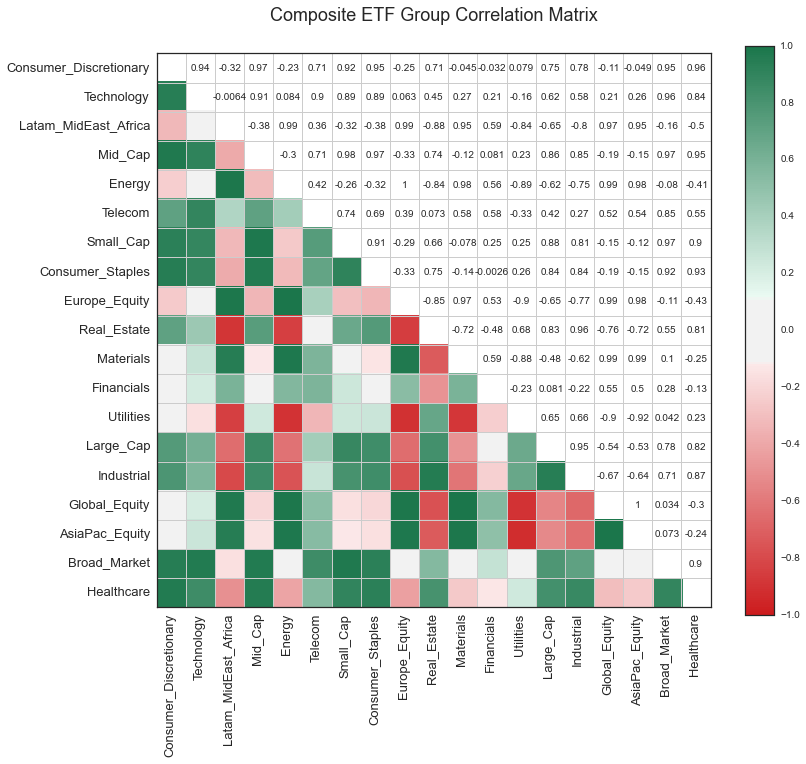

In [17]:
# ================================================================== #
# correlation matrix of composite ETF groups' risk adjusted returns
# ~~ plot code
f, ax = plt.subplots(figsize=(12,12))

cmap = sns.diverging_palette(h_neg=12, h_pos=144, s=91, l=44, sep=29, n=12, center='light',as_cmap=True)
sns.corrplot(cor, annot=True, sig_stars=False, diag_names=False, cmap=cmap, ax=ax)
ax.set_title('Composite ETF Group Correlation Matrix', fontsize=18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)

f.tight_layout()


___
_I conclude this analysis with the disclaimer that these calculations are presented `"as is"` and the data was aggregated from several sources. I recommend doing your own due diligence before taking any investment action and to stay within your personal risk/return objectives._ 

_I expect to refine this model as necessary to improve its utility as a macro valuation tool. Please contact me to report any errors._ 


####**For comments, questions, and feedback contact me via:**
####email:   **`bcr@blackarbs.com`** 
####twitter: **`@blackarbsCEO`**
___

_**Data Sources:** [Yahoo Finance](http://finance.yahoo.com/), [S&P SPDR ETFs](https://www.spdrs.com/product/)_<br />_**Acknowledgements:** Ipython Notebook styling modded from Plotly and Cam Davidson-Pilon custom CSS_

In [18]:
from IPython.core.display import HTML 

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [19]:
from IPython.core.display import HTML 
import requests

styles = requests.get("https://raw.githubusercontent.com/BlackArbsCEO/BlackArbsCEO.github.io/Equity-Analysis/Equity%20Analysis/custom.css")
HTML(styles.text)